In [1]:
## Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from opf_envs.envs.lr_opf_pyomo import OPFPyomo

In [2]:
## Parameters

current_dir = os.getcwd()

CONTROL_HORIZON_LEN = 72
delta_t = 5/60

Zbase = 1
Vbase = 4160
Sbase = (Vbase**2)/Zbase
w_to_kw_conv = 1000

num_bus = 13
load_bus = [1, 2, 4, 5, 6, 8, 9, 10, 11]
load_priority_weight = [1.0, 1.0, 0.9, 0.85, 0.8, 0.65, 0.45, 0.4, 0.3]
num_load_bus = len(load_bus)

psi = np.diag([100] * num_load_bus)   # Penalty factor for shedding prior restored load
alpha =  0.2                          # $/kWh -- penalty for wind power curtailment
beta = 0.2                            # $/kWh -- penalty for PV power curtailment

REWARD_SCALING_FACTOR = 0.001

wind_max_gen = 400
pv_max_gen = 300

mt_initial_fuel = 1000     # in kWh
es_initial_soc = 100       # in %

initial_active_restored_load = [0] * num_bus 
initial_reactive_restored_load = [0] * num_bus

In [3]:
## Renewable power forecasts

def get_renewable_power_forecast(error_level, start_index): 
    
    current_dir = os.getcwd()
    PSEUDO_FORECASTS_DIR = os.path.dirname(current_dir) + "/gym_opf_env/opf_envs/envs/data/exogenous_data/pfg_data/json_data"
        
    wind_max_gen = 400
    pv_max_gen = 300    
    
    CONTROL_HORIZON_LEN = 72
    datetimes = [] 
    
    # Select which folder to read in pseudo forecasts.
    percentage_error_level = str(int(error_level * 100))         
    percentage_error_level = '10' if percentage_error_level == '0' else percentage_error_level

    with open(os.path.join(PSEUDO_FORECASTS_DIR,
                           percentage_error_level + 'p/forecasts_' + str(start_index) + '.json'), 'r') as fp:
        episode_renewable_data = json.load(fp)

    actual_wt_profile = np.array(episode_renewable_data['actuals']['wind']) * wind_max_gen
    actual_pv_profile = np.array(episode_renewable_data['actuals']['pv']) * pv_max_gen
    
    renewable_pseudo_forecasts = episode_renewable_data['forecasts']

    step_time = pd.to_datetime(episode_renewable_data['time'])
    for _ in range(CONTROL_HORIZON_LEN):
        datetimes.append(step_time)
        step_time += pd.Timedelta('5M')
    
    return renewable_pseudo_forecasts, datetimes

/Users/aeseye/opt/anaconda3/envs/rl_reserve_policy/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  


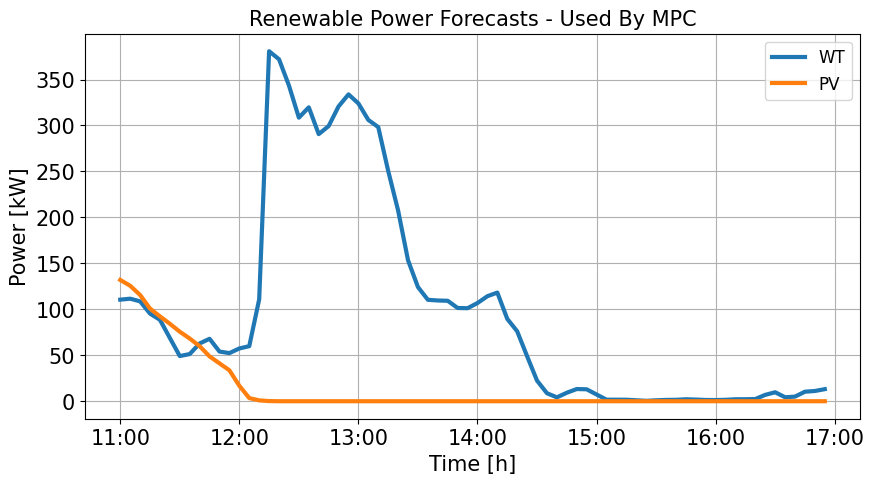

In [4]:
## Obtain the renewable power forecasts

error_level = 0.1
start_idx = 5099

renewable_pseudo_forecasts, datetimes = get_renewable_power_forecast(error_level, start_idx)

wt_power_forecast_mpc_used = []
pv_power_forecast_mpc_used = []

FORECAST_HORIZON = CONTROL_HORIZON_LEN

for sim_step in range(CONTROL_HORIZON_LEN):
    
    wind_power_forecast = \
    list(np.array(renewable_pseudo_forecasts[str(sim_step)]['wind'][:FORECAST_HORIZON])*wind_max_gen)      
      
    wt_power_forecast_mpc_used.append(wind_power_forecast[0])
    
    solar_power_forecast = \
    list(np.array(renewable_pseudo_forecasts[str(sim_step)]['pv'][:FORECAST_HORIZON])*pv_max_gen)    
    
    pv_power_forecast_mpc_used.append(solar_power_forecast[0])
    
    FORECAST_HORIZON -= 1
    
fig = plt.figure(figsize=(10,5))
plt.plot(wt_power_forecast_mpc_used, label='WT', linewidth = 3)
plt.plot(pv_power_forecast_mpc_used, label='PV', linewidth = 3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(11*12, 11*19, 12)], fontsize=15)
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Power [kW]", fontsize=15)
plt.title("Renewable Power Forecasts - Used By MPC", fontsize=15)
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [5]:
## Solve the LR OPF/MPC 

# Inputs

lr_model_obj = OPFPyomo()   # Load restoration (lr) OPF/MPC model object

solver = 'glpk'

prior_active_restored_load = initial_active_restored_load
prior_reactive_restored_load = initial_reactive_restored_load

mt_remaining_fuel = mt_initial_fuel
es_prior_soc = es_initial_soc

fuel_reserve = 0.0   # in kWh
soc_reserve = 20.0   # in %

look_ahead_periods = CONTROL_HORIZON_LEN

# Arrays to store the MPC results

P_mt = []
Q_mt = []

P_es = []
Q_es = []
SOC_es = []

P_wt_instant = []
P_wt_cut = []
Q_wt = []

P_pv_instant = []
P_pv_cut = []
Q_pv = []

P_restored = np.empty((0, num_load_bus))
Q_restored = np.empty((0, num_load_bus))

voltages = np.empty((0, num_bus))

episode_reward_history = []

for control_step in range(CONTROL_HORIZON_LEN):
    
    print("Control step:", control_step)

    # Update the wind and PV power forecasts 
    
    wind_power_forecast = \
    list(np.array(renewable_pseudo_forecasts[str(control_step)]['wind'][:look_ahead_periods])*wind_max_gen*w_to_kw_conv/Sbase)
    
    pv_power_forecast = \
    list(np.array(renewable_pseudo_forecasts[str(control_step)]['pv'][:look_ahead_periods])*pv_max_gen*w_to_kw_conv/Sbase)

    
    lr_model = lr_model_obj.build_load_restoration_model(look_ahead_periods, 
                            fuel_reserve, soc_reserve,
                            prior_active_restored_load, prior_reactive_restored_load, 
                            mt_remaining_fuel, es_prior_soc, 
                            wind_power_forecast, pv_power_forecast)

    opf_solution = lr_model_obj.compute_solution(lr_model, solver, solver_tee=False, solver_options=None)

    opf_converged, Prl, Pmt, Pes, Pwtb, Pwt_cut, \
    Ppvs, Ppv_cut, Qrl, Qmt, Qwtb, Qpvs, Qes, SOCes, v = opf_solution    
        
    # Apply the first control actions and discard the rest
    
    P_restored = np.append(P_restored, [Prl[:,0]], axis=0)
    Q_restored = np.append(Q_restored, [Qrl[:,0]], axis=0)
    
    P_mt.append(Pmt[0])
    Q_mt.append(Qmt[0])
    
    P_es.append(Pes[0])
    Q_es.append(Qes[0])
    SOC_es.append(SOCes[0])
      
    P_wt_instant.append(Pwtb[0])    
    P_wt_cut.append(Pwt_cut[0])
    Q_wt.append(Qwtb[0])    
    
    P_pv_instant.append(Ppvs[0])
    P_pv_cut.append(Ppv_cut[0])
    Q_pv.append(Qpvs[0])   
       
    voltages = np.append(voltages, [v[:,0]], axis=0) 
        
    # Calculate reward:
        # Consists of 3 parts: load restoration reward, load shedding penalty and renewable curtailment penalty

        # 1. Load restoration reward
    
    load_restoration_reward = np.dot(load_priority_weight, Prl[:,0]) + np.dot(load_priority_weight, Qrl[:,0])
    
        # 2. Load shedding penalty
    
    prior_active_restored_load_with_only_load_bus = []
    prior_reactive_restored_load_with_only_load_bus = []
    for l in load_bus:
        prior_active_restored_load_with_only_load_bus.append(prior_active_restored_load[l])
        prior_reactive_restored_load_with_only_load_bus.append(prior_reactive_restored_load[l])
            
    active_load_shedded = [max(0.0, (prior_active_restored_load_with_only_load_bus[idx] - Prl[:,0][idx])) \
                           for idx in range(num_load_bus)]
    reactive_load_shedded = [max(0.0, (prior_reactive_restored_load_with_only_load_bus[idx] - Qrl[:,0][idx])) \
                             for idx in range(num_load_bus)]
        
    print("Active Shedded Loads:", active_load_shedded)
    print("Reactive Shedded Loads:", reactive_load_shedded)           

    active_load_shedded_by_psi = np.matmul(psi, np.array(active_load_shedded).reshape([-1, 1]))
    reactive_load_shedded_by_psi = np.matmul(psi, np.array(reactive_load_shedded).reshape([-1, 1]))

    load_shedding_penalty = float(np.dot(load_priority_weight, active_load_shedded_by_psi)) + \
                            float(np.dot(load_priority_weight, reactive_load_shedded_by_psi))
    
        # 3. Renewable power curtailment penalty   

    renewable_power_curtailment_penalty = alpha*Pwt_cut[0] + beta*Ppv_cut[0]
   
    reward = (load_restoration_reward - load_shedding_penalty - renewable_power_curtailment_penalty)*REWARD_SCALING_FACTOR
       
    print("Reward:", reward)
    
    episode_reward_history.append(reward)        
                
    # Update the ES SOC and MT fuel status (for the next control step)
    
    es_prior_soc = SOCes[0]
    mt_remaining_fuel -= Pmt[0]*delta_t
    
    # Update the restored loads (for the next control step)
    
    for idx, b in enumerate(load_bus):
        prior_active_restored_load[b] = list(Prl[:,0])[idx]
        prior_reactive_restored_load[b] = list(Qrl[:,0])[idx]   
    
    # Update (decrease) the control horizon (for the next control step)
    
    look_ahead_periods -= 1
    
    print()
    
# End of MPC loop

P_restored = np.transpose(P_restored)
Q_restored = np.transpose(Q_restored)

voltages = np.transpose(voltages)

episode_reward = np.sum(episode_reward_history)

print("Episodic reward (Total):", episode_reward)

Control step: 0
Active Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reactive Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reward: 0.6205824350926678

Control step: 1
Active Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reactive Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reward: 0.6502091054974527

Control step: 2
Active Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reactive Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reward: 0.6514226939887103

Control step: 3
Active Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reactive Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reward: 0.653061026263659

Control step: 4
Active Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reactive Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reward: 0.6533773886464866

Control step: 5
Active Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reactiv

Active Shedded Loads: [0.0, 0.0, 0.0, 0.0, 0.4862611202895284, 0.0, 0.0, 0.0, 0.0]
Reactive Shedded Loads: [0.0, 0.0, 0.0, 1.8474111129762605e-13, 0.22882876248919004, 0.0, 0.0, 0.0, 0.0]
Reward: 0.6084224201843249

Control step: 45
Active Shedded Loads: [0.0, 0.0, 0.0, 3.495870259939693e-12, 1.2665318314177316, 0.0, 0.0, 0.0, 0.0]
Reactive Shedded Loads: [0.0, 0.0, 0.0, 1.9042545318370685e-12, 0.5960149794907013, 0.0, 0.0, 0.0, 0.0]
Reward: 0.515135828484773

Control step: 46
Active Shedded Loads: [0.0, 0.0, 0.0, 0.0, 2.412472790130536, 0.0, 0.0, 0.0, 0.0]
Reactive Shedded Loads: [0.0, 0.0, 0.0, 0.0, 1.1352813130025998, 0.0, 0.0, 0.0, 0.0]
Reward: 0.3774810418247541

Control step: 47
Active Shedded Loads: [0.0, 1.8474111129762605e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reactive Shedded Loads: [0.0, 0.0, 0.0, 5.115907697472721e-13, 0.0, 0.0, 0.0, 0.0, 0.0]
Reward: 0.6622063226366163

Control step: 48
Active Shedded Loads: [0.0, 0.0, 0.0, 0.0, 2.067077370562168, 0.0, 0.0, 0.0, 0.0]
Reac

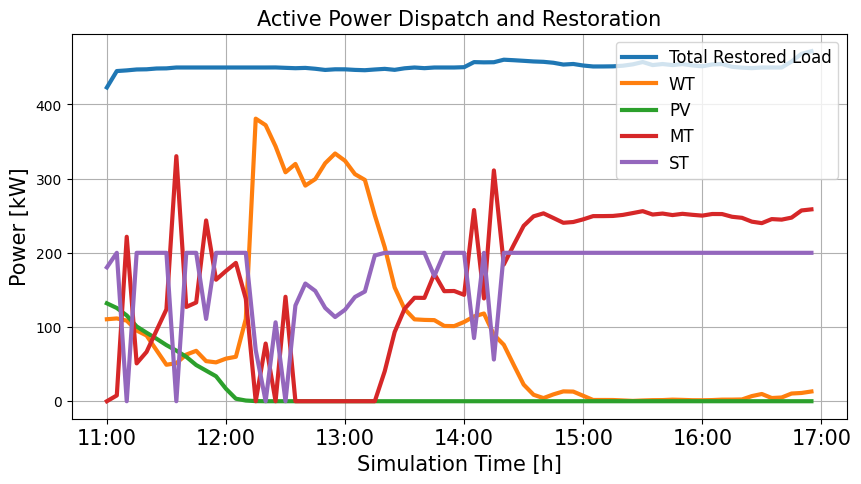

In [6]:
## Active power plot

P_restored_t = []
for idx in range(CONTROL_HORIZON_LEN):
    P_restored_t.append(sum(P_restored[:,idx]))

fig = plt.figure(figsize=(10,5))
plt.plot(P_restored_t, label='Total Restored Load', linewidth = 3)
plt.plot(P_wt_instant, label='WT', linewidth = 3)
plt.plot(P_pv_instant, label='PV', linewidth = 3)
plt.plot(P_mt, label='MT', linewidth = 3)
plt.plot(P_es, label='ST', linewidth = 3)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(11*12, 11*19, 12)], fontsize=15)
#plt.yticks(range(0, 901, 100), [str(int(c)) for c in range(0, 901, 100)], fontsize=15)
plt.xlabel("Simulation Time [h]", fontsize=15)
plt.ylabel("Power [kW]", fontsize=15)
plt.title("Active Power Dispatch and Restoration", fontsize=15)
plt.legend(fontsize=12)
plt.grid()
plt.show()

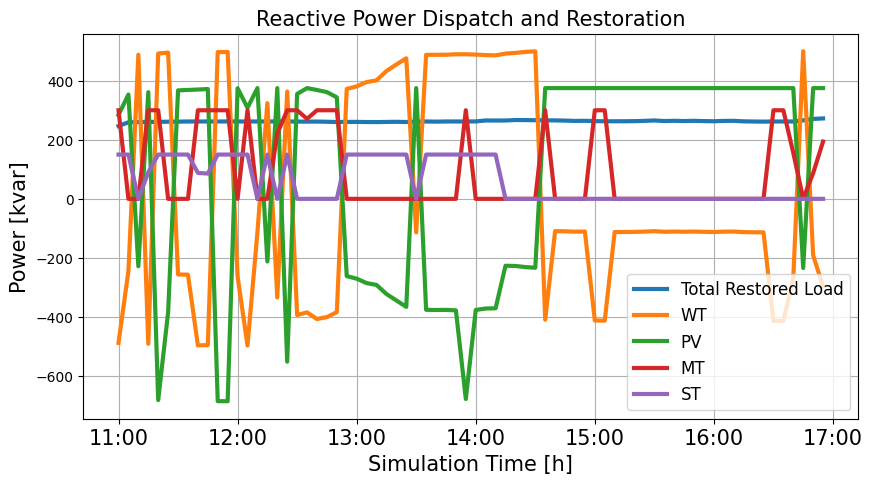

In [7]:
## Reactive power plot

Q_restored_t = []
for idx in range(CONTROL_HORIZON_LEN):
    Q_restored_t.append(sum(Q_restored[:,idx]))

fig = plt.figure(figsize=(10,5))
plt.plot(Q_restored_t, label='Total Restored Load', linewidth = 3)
plt.plot(Q_wt, label='WT', linewidth = 3)
plt.plot(Q_pv, label='PV', linewidth = 3)
plt.plot(Q_mt, label='MT', linewidth = 3)
plt.plot(Q_es, label='ST', linewidth = 3)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(11*12, 11*19, 12)], fontsize=15)
#plt.yticks(range(0, 901, 100), [str(int(c)) for c in range(0, 901, 100)], fontsize=15)
plt.xlabel("Simulation Time [h]", fontsize=15)
plt.ylabel("Power [kvar]", fontsize=15)
plt.title("Reactive Power Dispatch and Restoration", fontsize=15)
plt.legend(fontsize=12)
plt.grid()
plt.show()